## 1.3.1 图像数组表示

In [1]:
from PIL import Image
import numpy as np

In [2]:
im = np.array(Image.open('../../data/empire.jpg'))
im.shape, im.dtype

((800, 569, 3), dtype('uint8'))

In [3]:
im_L = np.array(Image.open('../../data/empire.jpg').convert('L'), 'f')
im_L.shape, im_L.dtype

((800, 569), dtype('float32'))

In [4]:
value = im[1,2,1]

In [5]:
value

133

In [6]:
im[1,2]

array([ 88, 133, 188], dtype=uint8)

In [7]:
im[:100, :50].sum(axis=2)

array([[409, 403, 403, ..., 397, 400, 397],
       [412, 409, 409, ..., 394, 400, 394],
       [412, 409, 406, ..., 394, 403, 400],
       ...,
       [445, 442, 441, ..., 429, 430, 430],
       [439, 439, 439, ..., 430, 430, 430],
       [442, 442, 442, ..., 430, 429, 429]], dtype=uint64)

## 1.3.2 灰度变换

In [8]:
import matplotlib.pyplot as plt

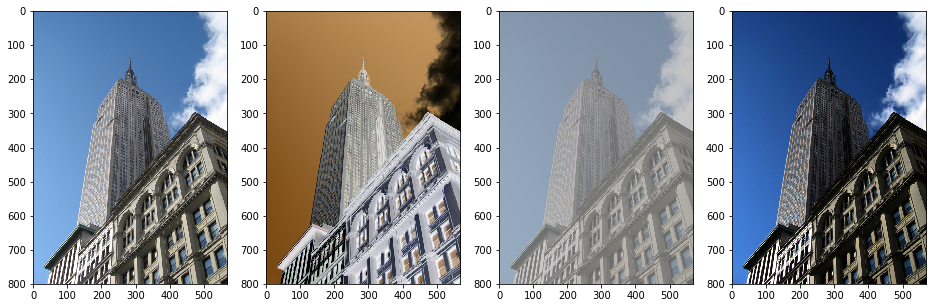

In [9]:
im = np.array(Image.open('../../data/empire.jpg'))
plt.figure(figsize=(16,8))
plt.subplot(1,4,1)
plt.imshow(im)
plt.subplot(1,4,2)
im2 = 255 - im # 对图像进行反向处理
plt.imshow(im2)
plt.subplot(1,4,3)
im3 = (100.0 / 255) * im + 100 # 将图像像素值变换到 100...200 区间
plt.imshow(im3.astype(np.uint8))
plt.subplot(1,4,4)
im4 = 255 * (im / 255) ** 2  # 对图像像素值求平方后得到的图像
plt.imshow(im4.astype(np.uint8))
plt.show()

In [10]:
im.min(), im.max()

(0, 255)

In [11]:
im2.min(), im2.max()

(0, 255)

In [12]:
im3.min(), im3.max()

(100.0, 200.0)

In [13]:
im4.min(), im4.max()

(0.0, 255.0)

In [14]:
pil_im = Image.fromarray(im)

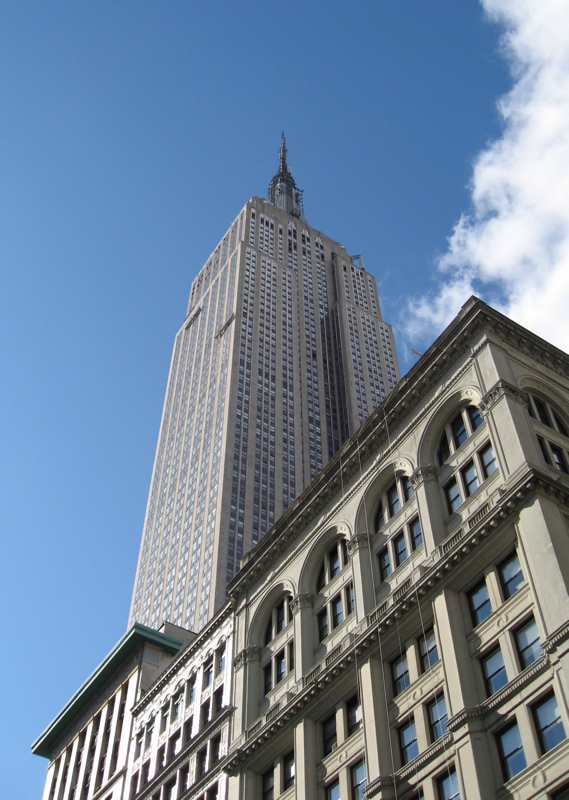

In [15]:
pil_im

In [16]:
pil_im = Image.fromarray(np.uint8(im))

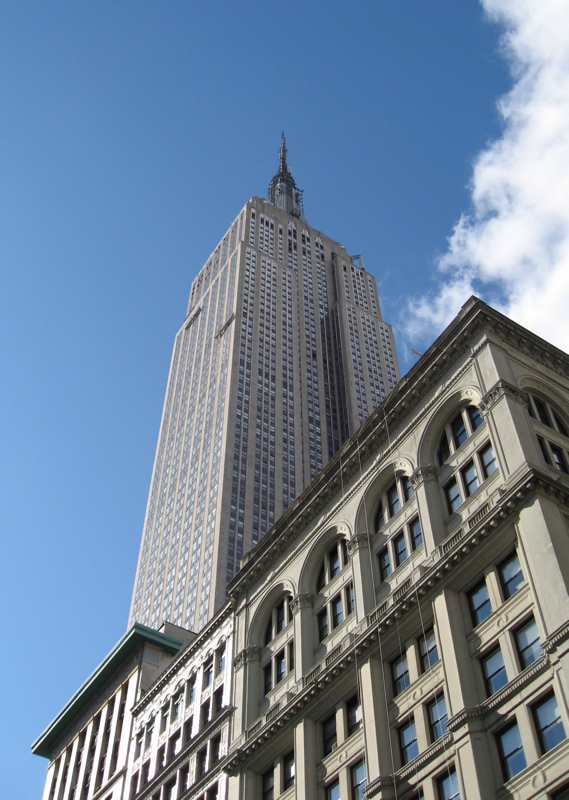

In [17]:
pil_im

## 1.3.3 图像缩放

In [18]:
def imreaize(im, sz):
    """ 使用 PIL 对象重新定义图像数组的大小 """
    pil_im = Image.fromarray(np.uint8(im))
    
    return np.array(pil_im.resize(sz))

## 1.3.4 直方图均衡化

In [30]:
def histeq(im, nbr_bins=256):
    """ 对一幅灰度图像进行直方图均衡化 """
    # 计算图像的直方图
    imhist, bins = np.histogram(im.flatten(), nbr_bins, density=True)
    # imhist: 频数, bins: 分箱边界
    cdf = imhist.cumsum() # 累计分布函数，注意是和，不是乘积
    cdf = 255 * cdf / cdf[-1] # 归一化
    
    # 使用累积分布函数的线性插值，计算新的像素值
    im2 = np.interp(im.flatten(), bins[:-1], cdf)
    return im2.reshape(im.shape), cdf

In [31]:
im = np.array(Image.open('../../data/AquaTermi_lowcontrast.JPG').convert('L'))
im2, cdf = histeq(im)

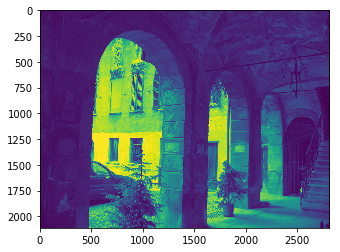

In [32]:
plt.imshow(im)
plt.show()

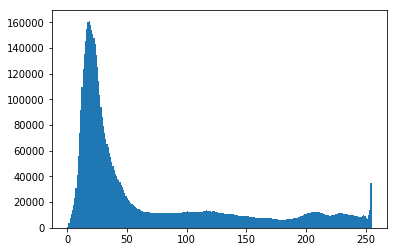

In [44]:
plt.hist(im.flatten(), bins=256)
plt.show()

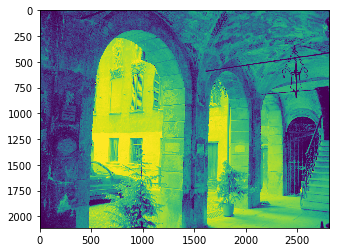

In [46]:
plt.imshow(im2)
plt.show()

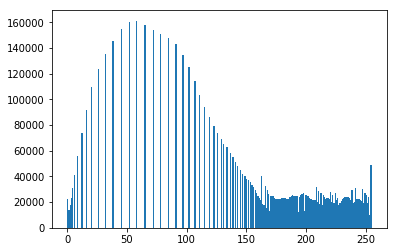

In [45]:
plt.hist(im2.flatten(), bins=256)
plt.show()

## 1.3.5 图像平均

In [47]:
def compute_average(imlist):
    """ 计算图像列表的平均图像 """

    # 打开第一幅图像，将其存储在浮点型数组中
    averageim = np.array(Image.open(imlist[0]), 'f')
    for imname in imlist[1:]:
        try:
            averageim += np.array(Image.open(imname))
        except:
            print('{}...skipped'.format(imname))
    averageim /= len(imlist)

    # 返回 uint8 类型的平均图像
    return np.array(averageim, 'uint8')

## 1.3.6 图像的主成分分析（PCA）

In [54]:
def pca(X):
    """
    主成分分析：
    输入：矩阵 X ，其中该矩阵中存储训练数据，每一行为一条训练数据
    返回：投影矩阵（按照维度的重要性排序）、方差和均值
    """

    # 获取维数
    num_data, dim = X.shape

    # 数据中心化
    mean_X = X.mean(axis=0) # dim
    X = X - mean_X

    if dim > num_data:
        # PCA- 使用紧致技巧
        M = np.dot(X, X.T)  # 协方差矩阵 num_data * num_data
        e, EV = np.linalg.eigh(M)  # 特征值和特征向量 num_data, num_data * num_data
        tmp = np.dot(X.T, EV).T  # 这就是紧致技巧 num_data * dim
        V = tmp[::-1]  # 由于最后的特征向量是我们所需要的，所以需要将其逆转 num_data * dim
        S = np.sqrt(e)[::-1]  # 由于特征值是按照递增顺序排列的，所以需要将其逆转 num_data
        for i in range(V.shape[1]): # dim
            # V[:, i] 第i列的一维向量 num_data
            V[:, i] /= S
    else:
        # PCA- 使用 SVD 方法
        U, S, V = np.linalg.svd(X) # U: num_data * num_data, S: num_data, V: dim * dim
        # 下面这句没看懂
        V = V[:num_data]  # 仅仅返回前 nun_data 维的数据才合理 num_data * dim, 因为dim < num_data, 返回的是 dim * dim

    # 返回投影矩阵、方差和均值
    return V, S, mean_X # num_data * dim, num_data, dim

In [99]:
import os
def get_imlist(path):
    """    Returns a list of filenames for 
        all jpg images in a directory. """

    return [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]

In [100]:
imlist = get_imlist('../../data/fontimages/a_thumbs/')

In [102]:
imlist[:5]

['../../data/fontimages/a_thumbs/2296_t.jpg',
 '../../data/fontimages/a_thumbs/121_t.jpg',
 '../../data/fontimages/a_thumbs/962_t.jpg',
 '../../data/fontimages/a_thumbs/164_t.jpg',
 '../../data/fontimages/a_thumbs/927_t.jpg']

In [103]:
im = np.array(Image.open(imlist[0]))
m, n = im.shape
imnbr = len(imlist)

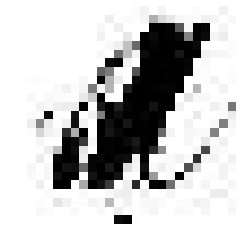

In [119]:
plt.gray()
plt.imshow(im)
plt.axis('off')
plt.show()

In [108]:
# 创建矩阵，保存所有压平后的图像数据
immatrix = np.array([np.array(Image.open(im)).flatten() for im in imlist], 'f')

In [109]:
# 执行 PCA 操作
V, S, imean = pca(immatrix)

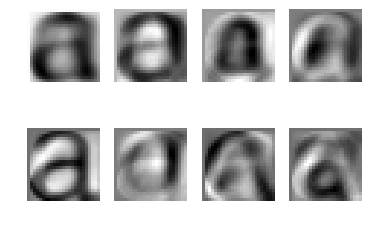

In [115]:
# 显示一些图像（均值图像和前7个模式）
plt.figure()
# plt.gray()
plt.subplot(2,4,1)
plt.imshow(imean.reshape(m, n))
plt.axis('off')
for i in range(7):
    plt.subplot(2,4,i+2)
    plt.imshow(V[i].reshape(m, n))
    plt.axis('off')
plt.show()

## 1.3.7 使用 pickle 模块

In [120]:
import pickle

In [121]:
# 打开文件并保存
with open('font_pca_modes.pkl', 'wb') as f:
    pickle.dump(imean, f)
    pickle.dump(V, f)

In [122]:
# 打开文件并载入
with open('font_pca_modes.pkl', 'rb') as f:
    imean_pkl = pickle.load(f)
    V_pkl = pickle.load(f)

In [124]:
sum(imean_pkl != imean)

0

In [126]:
(V != V_pkl).sum()

0